In [13]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import librosa
import librosa.display
import IPython.display as ipd
from ipywidgets import interact, IntSlider

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset, Audio

# ==============================================================================
# 1. PARÁMETROS GENERALES
# ==============================================================================

TARGET_SAMPLING_RATE = 16000 # Estandarizacion de la frecuencia de muestreo (SR) = 16000 Hz
N_MELS = 128                 # Altura de la imagen (N° de filtros Mel)
MAX_LENGTH = 125             # Ancho de la imagen (Frames de tiempo). Ajustar según el análisis del CSV.

# Parámetros de la CNN
NUM_CLASSES = 32             # Total de especies
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
NUM_EPOCHS = 3
N_FFT = 1024       # Reducido de 2048
HOP_LENGTH = 512   # Desplazamiento

# Clasificación de Cantos de Ballenas 🐋
Proyecto de aprendizaje supervisado usando el dataset **Marine Ocean Mammal Sound Dataset** (Hugging Face).

**Objetivo:** Explorar y preparar el dataset para un modelo de clasificación automática de cantos de ballenas y otros mamíferos marinos.


Dataset cargado: ardavey/marine_ocean_mammal_sound
Número de muestras en el split 'train': 1357
Columnas disponibles: ['audio', 'species', 'label']


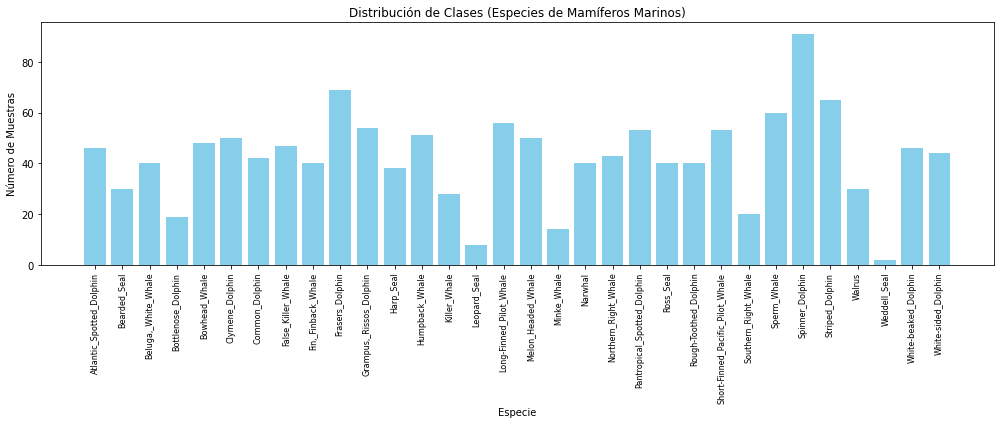

interactive(children=(IntSlider(value=0, description='Índice de Muestra', max=1356), Output()), _dom_classes=(…

In [ ]:
# ==============================================================================
# 2. CARGA DEL DATASET
# ==============================================================================

# Nombre del dataset en Hugging Face
DATASET_NAME = "ardavey/marine_ocean_mammal_sound"

# Carga la división 'train' del dataset
dataset = load_dataset(DATASET_NAME, split='train')

print(f"Dataset cargado: {DATASET_NAME}")
print(f"Número de muestras en el split 'train': {len(dataset)}")
print(f"Columnas disponibles: {dataset.column_names}")

dataset = dataset.cast_column("audio", Audio(sampling_rate=TARGET_SAMPLING_RATE))

# ==============================================================================
# 3. ANÁLISIS EXPLORATORIO: DISTRIBUCIÓN DE CLASES
# ==============================================================================

# Mapear las etiquetas numéricas a nombres de especies
label_names = dataset.features["label"].names
labels = [label_names[label] for label in dataset["label"]]
unique_labels, counts = np.unique(labels, return_counts=True)

# Visualizar la distribución de clases
plt.figure(figsize=(14, 6))
plt.bar(unique_labels, counts, color='skyblue')
plt.xticks(rotation=90, fontsize=8)
plt.title('Distribución de Clases (Especies de Mamíferos Marinos)')
plt.xlabel('Especie')
plt.ylabel('Número de Muestras')
plt.tight_layout()
plt.show()

# ==============================================================================
# 4. EXPLORADOR INTERACTIVO DE MUESTRAS
# ==============================================================================

# Obtener los límites del índice para el deslizador
MAX_IDX = len(dataset) - 1

def explore_sample(idx):
    """
    Carga, reproduce y visualiza el espectrograma Mel para un índice dado.
    """
    sample = dataset[idx]
    audio_array = sample["audio"]["array"]
    sampling_rate = sample["audio"]["sampling_rate"]
    label = label_names[sample["label"]]

    print(f"--- Muestra Seleccionada: Índice {idx} ---") #Recordar: Fila n+2 Excel -> Indice n del dataset
    print(f"Especie: {label}")
    print(f"Frecuencia de Muestreo (SR): {sampling_rate} Hz")
    
    # Reproductor de Audio
    ipd.display(ipd.Audio(audio_array, rate=sampling_rate))
    
    # ----------------------------------------------------
    # A. Forma de Onda (Dominio del Tiempo)
    # ----------------------------------------------------
    plt.figure(figsize=(14, 4))
    librosa.display.waveshow(audio_array, sr=sampling_rate)
    plt.title(f'Forma de Onda: {label} (Índice {idx})')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')
    plt.show()

    # ----------------------------------------------------
    # B. Espectrograma Mel
    # ----------------------------------------------------
    mel_spectrogram = librosa.feature.melspectrogram(
        y=audio_array,
        sr=sampling_rate,
        n_mels=N_MELS
        # NOTA: Aquí puedes añadir n_fft=1024 y hop_length=512 para solucionar los warnings.
    )

    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

    plt.figure(figsize=(10, 6))
    librosa.display.specshow(
        mel_spectrogram_db,
        x_axis='time',
        y_axis='mel',
        sr=sampling_rate
    )
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Espectrograma Mel: {label} ({N_MELS} Mel Bins)')
    plt.tight_layout()
    plt.show()
    
    # Mostrar dimensiones para la CNN
    print(f"Dimensiones del Espectrograma: {mel_spectrogram_db.shape} (Frames de Tiempo variable)")


# ==============================================================================
# 5. WIDGET INTERACTIVO
# ==============================================================================

# Crea el deslizador (slider) para seleccionar el índice de 0 al tamaño total del dataset
interact(
    explore_sample, 
    idx=IntSlider(min=0, max=MAX_IDX, step=1, value=0, description='Índice de Muestra')
);

## ENTRENAMIENTO

In [10]:
# ==============================================================================
# 2. CLASE DE DATASET PERSONALIZADA PARA PROCESAMIENTO
# ==============================================================================

class MarineSoundDataset(Dataset):
    def __init__(self, hf_dataset):
        self.hf_dataset = hf_dataset

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        sample = self.hf_dataset[idx]
        
        # 1. Extracción de Audio y Etiqueta
        audio_array = sample["audio"]["array"]
        sr = sample["audio"]["sampling_rate"]
        label = sample["label"] 
        
        # 2. Cálculo del Espectrograma Mel
        mel_spectrogram = librosa.feature.melspectrogram(
            y=audio_array,
            sr=sr,
            n_mels=N_MELS,
            n_fft=N_FFT,        # <--- AÑADIDO
            hop_length=HOP_LENGTH # <--- AÑADIDO
        )
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
        
        # 3. Convertir a Tensor de PyTorch y añadir dimensión de canal (C, F, T)
        tensor = torch.tensor(mel_spectrogram_db).float().unsqueeze(0) 

        # 4. Truncamiento y Padding para tamaño fijo
        _, F, T = tensor.shape
        
        if T > MAX_LENGTH:
            # Truncar: Tomar el centro del clip de audio
            start = (T - MAX_LENGTH) // 2
            tensor = tensor[:, :, start:start + MAX_LENGTH]
        elif T < MAX_LENGTH:
            # Rellenar: Añadir padding de ceros al final
            padding = torch.zeros((1, F, MAX_LENGTH - T))
            tensor = torch.cat([tensor, padding], dim=2)
        
        return tensor, torch.tensor(label, dtype=torch.long)

In [11]:
# ==============================================================================
# 3. ARQUITECTURA DE RED NEURONAL CONVOLUCIONAL (CNN)
# ==============================================================================

class SimpleWhaleClassifier(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES, input_size=(N_MELS, MAX_LENGTH)):
        super(SimpleWhaleClassifier, self).__init__()
        
        # Bloque 1: (1, 128, 125) -> (16, 64, 62)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        # Bloque 2: (16, 64, 62) -> (32, 32, 31)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        # Bloque 3: (32, 32, 31) -> (64, 16, 15)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        # Cálculo del tamaño de la capa lineal (flatten)
        # 64 canales * (128/8) * (125/8) = 64 * 16 * 15 = 15360 (aproximadamente)
        final_height = input_size[0] // 8
        final_width = input_size[1] // 8
        self.flatten_size = 64 * final_height * final_width
        
        # Capas Densa
        self.fc1 = nn.Linear(self.flatten_size, 128)
        self.fc2 = nn.Linear(128, num_classes) # Salida de 32 clases

    def forward(self, x):
        # Bloque 1
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        # Bloque 2
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        # Bloque 3
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        
        # Aplanar para la capa densa
        x = torch.flatten(x, 1) 
        
        # Capas Densa
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [12]:
# ==============================================================================
# 4. EJECUCIÓN DEL PIPELINE Y ENTRENAMIENTO BÁSICO
# ==============================================================================

# 1. Carga del Dataset
DATASET_NAME = "ardavey/marine_ocean_mammal_sound"
hf_dataset = load_dataset(DATASET_NAME, split='train')
hf_dataset = hf_dataset.cast_column("audio", Audio(sampling_rate=TARGET_SAMPLING_RATE))

# 2. División de Datos (80% Entrenamiento, 20% Validación)
split_data = hf_dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = MarineSoundDataset(split_data["train"])
val_dataset = MarineSoundDataset(split_data["test"])

# 3. DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Tamaño del set de entrenamiento: {len(train_dataset)}")
print(f"Tamaño del set de validación: {len(val_dataset)}")


# 4. Configuración del Modelo y Optimización
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleWhaleClassifier(num_classes=NUM_CLASSES).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(f"Modelo cargado en dispositivo: {device}")
print(f"Iniciando entrenamiento por {NUM_EPOCHS} épocas...")

# 5. Bucle de Entrenamiento
for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0
    
    for inputs, labels in tqdm(train_loader, desc=f"Época {epoch+1}"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass y optimización
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    
    # 6. Evaluación simple en el set de validación
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            # La clasificación es el índice con el valor máximo
            _, predicted = torch.max(outputs.data, 1) 
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    
    print(f"\n--- RESULTADOS ÉPOCA {epoch+1} ---")
    print(f"Pérdida (Loss) de entrenamiento: {avg_loss:.4f}")
    print(f"Precisión (Accuracy) de validación: {accuracy:.2f}%")

Tamaño del set de entrenamiento: 1085
Tamaño del set de validación: 272
Modelo cargado en dispositivo: cuda
Iniciando entrenamiento por 3 épocas...


Época 1:   0%|          | 0/34 [00:00<?, ?it/s]

/home/zppay/.local/lib/python3.8/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=859
  warnings.warn(



--- RESULTADOS ÉPOCA 1 ---
Pérdida (Loss) de entrenamiento: 2.8972
Precisión (Accuracy) de validación: 30.88%


Época 2:   0%|          | 0/34 [00:00<?, ?it/s]


--- RESULTADOS ÉPOCA 2 ---
Pérdida (Loss) de entrenamiento: 2.1343
Precisión (Accuracy) de validación: 43.38%


Época 3:   0%|          | 0/34 [00:00<?, ?it/s]


--- RESULTADOS ÉPOCA 3 ---
Pérdida (Loss) de entrenamiento: 1.6356
Precisión (Accuracy) de validación: 48.16%
